# 1. Подготовка

Сперва загрузим файл, посмотрим на данные и подготовим их для обучения

In [1]:
import pandas as pd

import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
data=pd.read_csv('/datasets/toxic_comments.csv')
print(data.head(5))

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0


In [3]:
print(data['toxic'].value_counts())

0    143346
1     16225
Name: toxic, dtype: int64


Есть явный дисбаланс классов, необходимо учесть это при обучении

In [4]:
#пример отрицательной токсичности
data[data['toxic']==1].sample(n=1)['text'].iloc[0]

"Who died and left you queen of SPUI's page??? SPUI said he likes vandalism on his page and doesn't want it reverted. I'm not sure how many different ways saying it will will be required to get it through your thick skull."

In [5]:
#пример положительной токсичности
data[data['toxic']==0].sample(n=1)['text'].iloc[0]

"conspiracy section \nI realize that there has been extensive discussion about the hoax section but if we are going to include this section it should at least be well written. \nWhy are we talking about the retroreflectors when the NASA's recent lunar orbiter has given us photographic evidence of the landings? And many conspiracy theories deal only with the manned landings, the existence of the reflectors do not defend against these arguments. \nThe sentence speculating why there are so many conspiracy theories is pure speculation and isn't npov.\nI realize that it's important to compromise especially on more controversial topics but I can't believe that anybody is happy with the current version of this section. I would be more than happy to rewrite it but I don't want to step on any toes."

Подготовка данных

In [6]:
stop_words = stopwords.words('english')
stop_words.remove('not') 
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):
    
    
  # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review)
    review =  re.sub('[^A-Za-z0-9]+', ' ', review) 
  
  # lowercase
    review = review.lower()
  
  # tokenization
    tokens = nltk.word_tokenize(review) 
  
  # stop_words removal
    review = [word for word in tokens if word not in stop_words] 
  
  # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
  
  
    review = ' '.join(review)
    review=review.drop_duplicates(inplace=True)
  
    return review

In [7]:
data['preprocessed_text'] = data['text'].apply(lambda review: data_preprocessing(review))
data.head()

,text,toxic,preprocessed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really not trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


In [8]:

y = data['toxic'].values
data.drop(columns=['toxic','text' ], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (111699, 1) (111699,)
Test data: (47872, 1) (47872,)


# 2. Обучение

Сравним два варианта BOW и TFIDF, для котроля качеста будем оценивать f1 меру и для дополнительной информации посмотрим confusion matrix

BOW

In [9]:
vect = CountVectorizer(min_df=10)

X_train_text_bow = vect.fit_transform(X_train['preprocessed_text'])
X_test_text_bow = vect.transform(X_test['preprocessed_text'])

print('X_train_review_bow shape: ', X_train_text_bow.shape)
print('X_test_review_bow shape: ', X_test_text_bow.shape)

X_train_review_bow shape:  (111699, 16473)
X_test_review_bow shape:  (47872, 16473)


TFIDF

In [10]:
vectorizer = TfidfVectorizer(min_df=10)

X_train_text_tfidf = vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_text_tfidf = vectorizer.transform(X_test['preprocessed_text'])

print('X_train_review_tfidf shape: ', X_train_text_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_text_tfidf.shape)

X_train_review_tfidf shape:  (111699, 16473)
X_test_review_tfidf shape:  (47872, 16473)


# Обучение моделей

Naive Bayes: BOW

Test F1:  0.7228721258572005


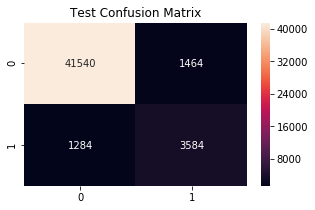

In [11]:

clf = MultinomialNB()
clf.fit(X_train_text_bow, y_train)

y_pred = clf.predict(X_test_text_bow) 
print('Test F1: ', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()


Naive Bayes: TFIDF

Test f1:  0.6319682235310231


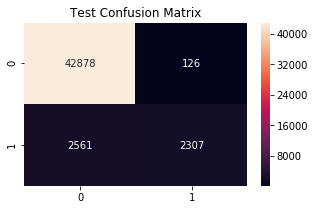

In [12]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_text_tfidf, y_train)

y_pred = clf.predict(X_test_text_tfidf)
print('Test f1: ',f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
С наскока наивный байесовксий классификатор не показал нужного качества результатов

Logistic Regression: TFIDF

Test f1:  0.7749795009956659


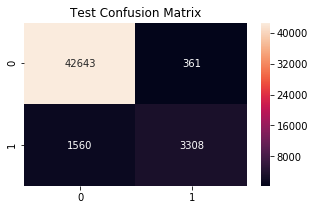

In [13]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train_text_tfidf, y_train)

y_pred = clf.predict(X_test_text_tfidf)
print('Test f1: ', f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

Пороговое значение f1=0.75 пройдено, но посмотрим на результаты еще пары-тройки моделей, вдруг найдем варианты получше 

CatBoost

Learning rate set to 0.063639
0:	learn: 0.6266103	total: 4.42s	remaining: 1h 13m 33s
1:	learn: 0.5726595	total: 8.01s	remaining: 1h 6m 37s
2:	learn: 0.5249835	total: 11.6s	remaining: 1h 4m 18s
3:	learn: 0.4824750	total: 15.2s	remaining: 1h 3m 7s
4:	learn: 0.4458265	total: 18.8s	remaining: 1h 2m 23s
5:	learn: 0.4152709	total: 22.4s	remaining: 1h 1m 52s
6:	learn: 0.3898904	total: 26s	remaining: 1h 1m 29s
7:	learn: 0.3677510	total: 29.6s	remaining: 1h 1m 11s
8:	learn: 0.3487446	total: 33.2s	remaining: 1h 56s
9:	learn: 0.3323382	total: 36.8s	remaining: 1h 44s
10:	learn: 0.3182826	total: 40.4s	remaining: 1h 32s
11:	learn: 0.3062628	total: 44s	remaining: 1h 23s
12:	learn: 0.2956786	total: 47.6s	remaining: 1h 14s
13:	learn: 0.2865785	total: 51.2s	remaining: 1h 6s
14:	learn: 0.2789354	total: 54.7s	remaining: 59m 52s
15:	learn: 0.2719210	total: 58.4s	remaining: 59m 52s
16:	learn: 0.2657862	total: 1m 1s	remaining: 59m 40s
17:	learn: 0.2603040	total: 1m 5s	remaining: 59m 33s
18:	learn: 0.2555572	

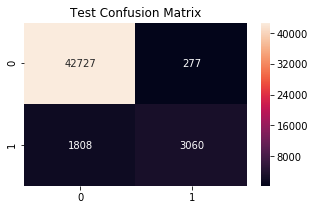

In [14]:
clf = CatBoostClassifier()
clf.fit(X_train_text_tfidf, y_train)

y_pred = clf.predict(X_test_text_tfidf)
print('Test f1: ', f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

RandomForestClassifier

Test f1:  0.7215771649733913


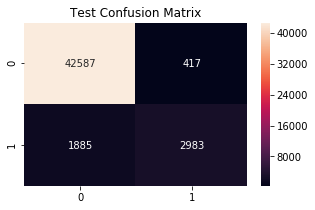

In [16]:

clf = RandomForestClassifier()
clf.fit(X_train_text_tfidf, y_train)

y_pred = clf.predict(X_test_text_tfidf)
print('Test f1: ', f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

# 3. Выводы

Итого: данные подготовлены, модели обучены - лучшим вариантом стала Логистическая регрессия с f1_score 0.775